In [1]:
import torch

from sbi import utils
from sbi.inference import SNPE_C, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

torch.random.manual_seed(1234567890)

# 事前分布を設定
prior = utils.BoxUniform(low=-6.28 * torch.ones(1), high=6.28 * torch.ones(1))

# シミュレータを設定
def simulator(theta):
    noise = torch.randn(theta.shape) * 0.2
    x = torch.cos(theta + noise)
    return x

# prior, simulator の形式をチェック
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

# NPE学習のためのデータを生成
theta, x = simulate_for_sbi(
    simulator, prior, num_simulations=10000, show_progress_bar=False
)

# NPE学習を実行
# （SNPE-Cのクラスを使っているが、1ラウンドしか回さないのでnon-sequential NPE）
inference = SNPE_C(prior=prior, density_estimator="nsf")
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 63 epochs.

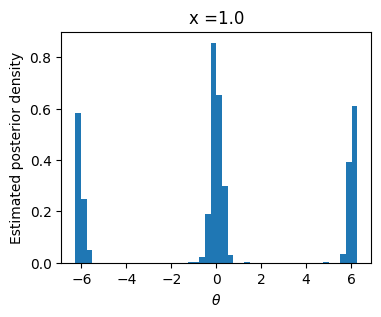

In [2]:
# x=x_o について、推定した事後分布を表示
x_o = 1.0

posterior_samples = posterior.sample(
    (1000,), x=torch.tensor([x_o]), show_progress_bars=False
)
plt.figure(figsize=(4, 3))
plt.hist(posterior_samples.numpy(), bins=50, density=True)
plt.xlabel(r"$\theta$")
plt.ylabel("Estimated posterior density")
plt.title(r"x =" + str(x_o))
plt.show()

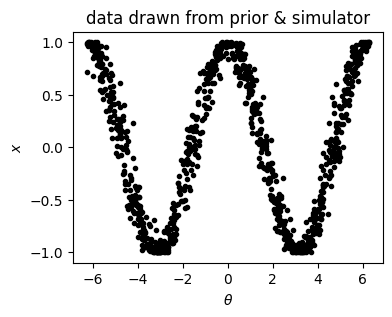

In [3]:
# 参考のため、事前分布に基づくデータ（NPEの訓練で使われるものとほぼ同じ）を表示
theta_sample = prior.sample((1000,))
plt.figure(figsize=(4, 3))
plt.plot(theta_sample, simulator(theta_sample), 'k.')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$x$')
plt.title("data drawn from prior & simulator")
plt.show()